In [1]:
import networkx as nx
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import math
import random
import itertools
import matplotlib

# latex style plots
matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.size"] = "10"

from IPython.display import clear_output

# Problem 1

## (Question a-1)

In [2]:
def symmetric_regular_graph(n : int = 8, k : int = 4):
    """Generate a symmetric k-regular undirected graph with N nodes where every node is directly connected
    to the K nodes whose index is closest to their own modulo N.

    Args:
        n (int, optional): number of nodes. Defaults to 8.
        k (int, optional): number of links to every node. Defaults to 4.
    
    Returns:
        graph: the symmetric k-regular undirected graph
    """
    if (k%2) != 0:
        raise ValueError("The parameter K must be an even number")
    elif k >= n:
        raise ValueError("The parameter K must less than the total number of nodes")

    G = nx.Graph()
    G.add_nodes_from(range(n))

    half_k = int(k/2)

    for node in range(n):
        for x in range(1, half_k+1):
            index_to_add = (node + x) % n
            G.add_edge(node, index_to_add)
            G.add_edge(index_to_add, node)
    for x in range(1, half_k+1):
        index_to_add = (node - x) % n
        G.add_edge(node, index_to_add)
        G.add_edge(index_to_add, node)

    return G

In [3]:
def simulate_contagion(G:nx.Graph, 
                       beta:float=0.3, 
                       rho:float=0.7,
                       N:int=100, 
                       n_weeks:int=15,
                       epidemic_model:str="sir",
                       vaccination_scheme:list=None,
                       ring_vaccination:bool=False,
                       n_infected_t0:int=10,
                       seed:int=None):
    """Simulate a contagion on the given graph according to the given epidemic model.

    Args:
        G (nx.Graph): graph used to simulate the contagion.
        beta (float, optional): probability that the infection is spread from an infected individual to a susceptible one. Defaults to 0.3.
        rho (float, optional):  probability that an infected individual will recover during one time step. Defaults to 0.7.
        N (int, optional): number of simulations. Defaults to 100.
        n_infected_t0 (int, optional): number of infected at time t0. Defaults to 10.
        n_weeks (int, optional): number of weeks through which the model is simulated. Defaults to 15.
        epidemic_model (str, optional): epidemic model to follow. Defaults to "sir", which is the only one implemented. 
        vaccination_scheme (list, optional) : if a vaccination scheme is introduced, vector representing Vacc(t) as per problem specifications
        seed (int, optional): seed to reproduce results.
    
    Returns:
        dict: average number of newly infected individuals each week
        dict: average total number of susceptible, infected, and recovered individuals each week
    """
    # set the seed, to reproduce results
    if seed is not None:
        np.random.seed(seed)
    # compute the number of nodes in the graph. Will come in handy later.
    n_nodes = len(G.nodes)
    if epidemic_model.lower() == "sir":
        possible_states = ["s", "i", "r"]
    else:
        raise ValueError("The only implemented model is SIR")

    # initialise variables to store results to answer the questions
    recap_per_week = {
        state : np.zeros((N, n_weeks)) for state in possible_states
    }
    recap_per_week["new infected"] = np.zeros((N, n_weeks))

    vaccination = True if vaccination_scheme is not None else False
    
    if vaccination:
        if len(vaccination_scheme) != n_weeks:
            raise ValueError("Vacc(t) should be defined for every week.")
        # we now have another possible state, the one of vaccianted people
        possible_states.append("v")
        # initialise variable whick keeps track of the average number of vaccinated each week
        recap_per_week["new vaccinated"] = np.zeros((N, n_weeks))

    for sim in tqdm(range(N), desc = "Simulating contagion"):
        # initialise the status of the system at t = 0.
        # We start with all S and 10 random I.
        node_states = {node: "s" for node in G.nodes}
        # we pick at random 10 nodes and make them infected.
        # I am not using G.nodes but range(len(G.nodes)) because G.nodes returns an array NodeView where the nodes are in 'random order'.
        # Since we want our results to be reproducible, we need to maintain the order.
        infected_nodes = np.random.choice(range(n_nodes), size = n_infected_t0, replace = False)
        for infected in infected_nodes:
            node_states[infected] = "i"

        # start the simulation
        for week in range(n_weeks):
            if vaccination:
                # jab people amongst the non-vaccinated
                # isolate non_vaccinated
                non_vaccinated = [node for node, state in node_states.items() if state != "v"]
                # compute how many people are already vaccinated
                n_vaccinated = n_nodes - len(non_vaccinated)
                # compute how many there are
                n_nonvacc = len(non_vaccinated)
                # work out how many need to receive their jab
                # vacc(t) refers to the global population. We need to convert the proportion of population in proportion of nonvaccinated
                proportion_population_week = vaccination_scheme[week]
                if proportion_population_week > 0:
                    # the number of vaccinated + the number of new vaccinated should be proportion_population_week% of the total population
                    # convert this proportion into number of people
                    target_n_vaccinations = n_nodes * proportion_population_week
                    # work out the number of new vaccinations
                    n_people_to_jab = target_n_vaccinations - n_vaccinated
                    # probability of getting vaccine is proportional to number of infected nodes in ring vaccinations schemes
                    p_vax = np.fromiter(map(lambda novax: len([infected for infected in G.neighbors(novax) if node_states[novax]=="i"]), non_vaccinated), dtype=float)
                    p_vax = np.fromiter(map(lambda p: 1e-6 if p==0 else p, p_vax), dtype=float)
                    
                    if ring_vaccination: 
                        new_vaccinated = np.random.choice(
                            non_vaccinated, int(n_people_to_jab), replace = False, p = p_vax / p_vax.sum()
                        )
                    else: 
                        new_vaccinated = np.random.choice(
                            non_vaccinated, int(n_people_to_jab), replace = False
                        )
                    
                    # vaccination is immediately effective. 
                    for v in new_vaccinated:
                        node_states[v] = "v"
                else:
                    new_vaccinated = []
                
            # isolate the susceptibles
            susceptibles = [node for node, state in node_states.items() if state == "s"]
            if len(susceptibles) > 0:
                # retrieve how many infected in the neighbourhood of each susceptible
                # variable to keep track of the number of new infected
                new_infected = []
                for susceptible in susceptibles:
                    # m is the number of infected neighbours, as per the problem specifications
                    m = len([neighbour for neighbour in G.neighbors(susceptible) if node_states[neighbour] == "i"])
                    # compute the probability of infection, according to the formula given in the text
                    p_infection = 1 - (1 - beta) ** m
                    # susceptible becomes infected with probability p_infection
                    if np.random.rand() < p_infection:
                        new_infected.append(susceptible)

            # isolate the infected
            infected_people = np.array([node for node, state in node_states.items() if state == "i"])
            n_infected = len(infected_people)
            if n_infected > 0:
                # for each one of them, pick a random number
                # if this number < rho, infected becomes removed.
                # probabilities of recovery
                probs_recovery = np.random.rand(n_infected, 1).reshape(n_infected,)
                # recovery or not
                recovery = np.array([prob_recovery < rho for prob_recovery in probs_recovery])
                # isolate the recovered
                recovered = infected_people[recovery]
                # make them R
                for r in recovered:
                    node_states[r] = "r"

            # turn the susceptibles into infected
            for new_i in new_infected:
                node_states[new_i] = "i"

            # how many individuals in total are susceptible/infected/recovered at each week (to answer question 1.1.2)
            if vaccination:
                epidemic_states = possible_states[:len(epidemic_model)]
                for state in epidemic_states:
                    recap_per_week[state][sim, week] = list(node_states.values()).count(state) 
                recap_per_week["new infected"][sim, week] = len(new_infected) 
                recap_per_week["new vaccinated"][sim, week] = len(new_vaccinated) 
            else:
                for state in possible_states:
                    recap_per_week[state][sim, week] = list(node_states.values()).count(state)
                recap_per_week["new infected"][sim, week] = len(new_infected) 

    return(recap_per_week)

In [4]:
# number of nodes in the graph
n = 500
# generate a regular graph
G = symmetric_regular_graph(n=n, k=4)

# parameters for the simulation
beta = 0.3
beta2 = beta * 2
rho = 0.7

# parameters for the loop
N = 100
n_weeks = 15

# print results
recap_per_week = simulate_contagion(G, beta, rho, N, n_weeks)
recap_per_week_06 = simulate_contagion(G, beta2, rho, N, n_weeks)

for state, recap in recap_per_week.items():
    if len(state) == 1:
        state = state.upper()
        state = "'" + state + "'"
    print(f"Average number of {state} per week: {recap.mean(axis=0)}")

Simulating contagion: 100%|██████████| 100/100 [00:00<00:00, 136.99it/s]

Average number of 'S' per week: [478.25 467.27 458.6  452.24 447.69 444.28 442.   440.16 438.76 437.73
 437.07 436.47 436.09 435.87 435.7 ]
Average number of 'I' per week: [14.92 15.6  13.6  10.57  7.57  5.91  4.12  3.1   2.39  1.78  1.29  0.92
  0.61  0.37  0.28]
Average number of 'R' per week: [ 6.83 17.13 27.8  37.19 44.74 49.81 53.88 56.74 58.85 60.49 61.64 62.61
 63.3  63.76 64.02]
Average number of new infected per week: [11.75 10.98  8.67  6.36  4.55  3.41  2.28  1.84  1.4   1.03  0.66  0.6
  0.38  0.22  0.17]


In [5]:
save=False # switch to True to save plots

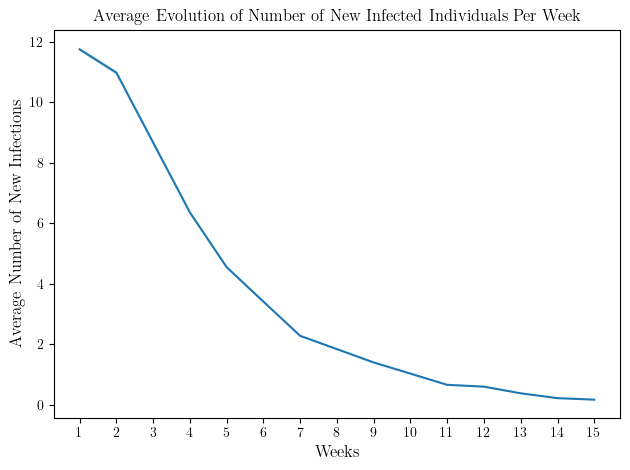

In [6]:
avg_newinfections = recap_per_week["new infected"].mean(axis=0)
std_newinfections = recap_per_week["new infected"].std(axis=0)

ci = 1.96/len(recap_per_week["new infected"])

fig, ax = plt.subplots()

ax.plot(range(1,16), avg_newinfections)
ax.fill_between(range(1,16), y1=avg_newinfections - ci*std_newinfections, y2=avg_newinfections + ci*std_newinfections, alpha=0.2)

ax.set_xlabel("Weeks", fontsize=12)
ax.set_ylabel("Average Number of New Infections", fontsize=12)
ax.set_title("Average Evolution of Number of New Infected Individuals Per Week")

ax.set_xticks(range(1,16))

fig.tight_layout()
if save:
    fig.savefig("ex111_a.pdf")
plt.show()

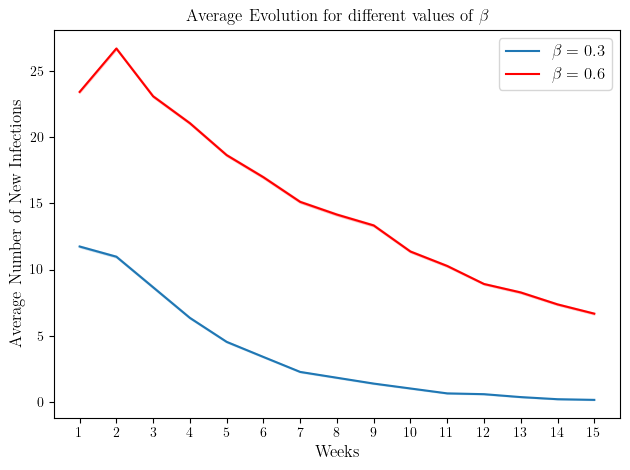

In [7]:
avg_newinfections = recap_per_week["new infected"].mean(axis=0)
std_newinfections = recap_per_week["new infected"].std(axis=0)

avg_newinfections_06 = recap_per_week_06["new infected"].mean(axis=0)
std_newinfections_06 = recap_per_week_06["new infected"].std(axis=0)

ci = 1.96/len(recap_per_week["new infected"])

fig, ax = plt.subplots()

ax.plot(range(1,16), avg_newinfections, label=r"$\beta=0.3$", color="tab:blue")
ax.fill_between(range(1,16), y1=avg_newinfections - ci*std_newinfections, y2=avg_newinfections + ci*std_newinfections, alpha=0.2, color="tab:blue")

ax.plot(range(1,16), avg_newinfections_06, label=r"$\beta=0.6$", color="red")
ax.fill_between(range(1,16), y1=avg_newinfections_06 - ci*std_newinfections_06, y2=avg_newinfections_06 + ci*std_newinfections_06, alpha=0.2, color="red")

ax.set_xlabel("Weeks", fontsize=12)
ax.set_ylabel("Average Number of New Infections", fontsize=12)
ax.set_title(r"Average Evolution for different values of $\beta$", fontsize=12)

ax.set_xticks(range(1,16))
ax.legend(fontsize=12)
fig.tight_layout()
if save:
    fig.savefig("ex111_a_bis.pdf")
plt.show()

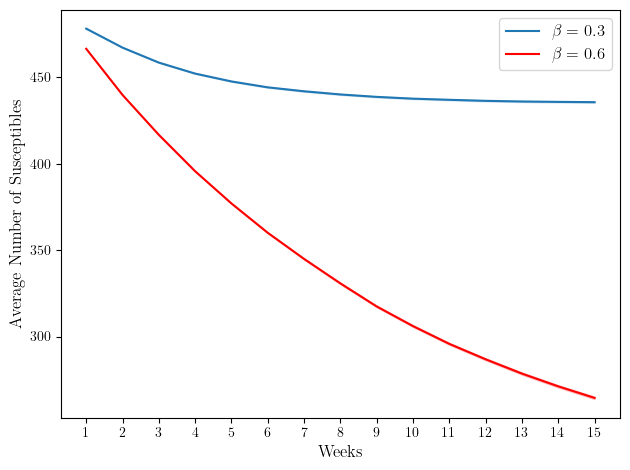

In [8]:
avg_susceptible = recap_per_week["s"].mean(axis=0)
std_susceptible = recap_per_week["s"].std(axis=0)

avg_susceptible_06 = recap_per_week_06["s"].mean(axis=0)
std_susceptible_06 = recap_per_week_06["s"].std(axis=0)

ci = 1.96/len(recap_per_week["s"])

fig, ax = plt.subplots()

ax.plot(range(1,16), avg_susceptible, label=r"$\beta=0.3$", color="tab:blue")
ax.fill_between(range(1,16), y1=avg_susceptible - ci*std_susceptible, y2=avg_susceptible + ci*std_susceptible, alpha=0.2, color="tab:blue")

ax.plot(range(1,16), avg_susceptible_06, label=r"$\beta=0.6$", color="red")
ax.fill_between(range(1,16), y1=avg_susceptible_06 - ci*std_susceptible_06, y2=avg_susceptible_06 + ci*std_susceptible_06, alpha=0.2, color="red")

ax.set_xlabel("Weeks", fontsize=12)
ax.set_ylabel("Average Number of Susceptibles", fontsize=12)

ax.set_xticks(range(1,16))
ax.legend(fontsize=12)
fig.tight_layout()
if save:
    fig.savefig("ex111_a_tris_S.pdf")
plt.show()

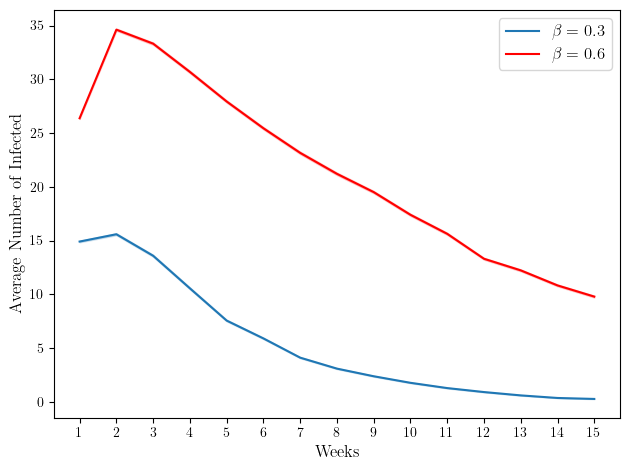

In [9]:
avg_infected = recap_per_week["i"].mean(axis=0)
std_infected = recap_per_week["i"].std(axis=0)

avg_infected_06 = recap_per_week_06["i"].mean(axis=0)
std_infected_06 = recap_per_week_06["i"].std(axis=0)

ci = 1.96/len(recap_per_week["i"])

fig, ax = plt.subplots()

ax.plot(range(1,16), avg_infected, label=r"$\beta=0.3$", color="tab:blue")
ax.fill_between(range(1,16), y1=avg_infected - ci*std_infected, y2=avg_infected + ci*std_infected, alpha=0.2, color="tab:blue")

ax.plot(range(1,16), avg_infected_06, label=r"$\beta=0.6$", color="red")
ax.fill_between(range(1,16), y1=avg_infected_06 - ci*std_infected_06, y2=avg_infected_06 + ci*std_infected_06, alpha=0.2, color="red")

ax.set_xlabel("Weeks", fontsize=12)
ax.set_ylabel("Average Number of Infected", fontsize=12)

ax.set_xticks(range(1,16))
ax.legend(fontsize=12)
fig.tight_layout()
if save:
    fig.savefig("ex111_a_tris_I.pdf")
plt.show()

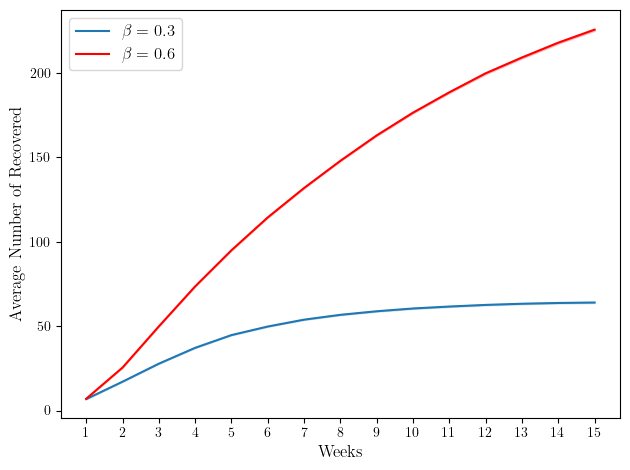

In [10]:
avg_recovered = recap_per_week["r"].mean(axis=0)
std_recovered = recap_per_week["r"].std(axis=0)

avg_recovered_06 = recap_per_week_06["r"].mean(axis=0)
std_recovered_06 = recap_per_week_06["r"].std(axis=0)

ci = 1.96/len(recap_per_week["r"])

fig, ax = plt.subplots()

ax.plot(range(1,16), avg_recovered, label=r"$\beta=0.3$", color="tab:blue")
ax.fill_between(range(1,16), y1=avg_recovered - ci*std_recovered, y2=avg_recovered + ci*std_recovered, alpha=0.2, color="tab:blue")

ax.plot(range(1,16), avg_recovered_06, label=r"$\beta=0.6$", color="red")
ax.fill_between(range(1,16), y1=avg_recovered_06 - ci*std_recovered_06, y2=avg_recovered_06 + ci*std_recovered_06, alpha=0.2, color="red")

ax.set_xlabel("Weeks", fontsize=12)
ax.set_ylabel("Average Number of Recovered", fontsize=12)

ax.set_xticks(range(1,16))
ax.legend(fontsize=12)
fig.tight_layout()

if save:
    fig.savefig("ex111_a_tris_R.pdf")
plt.show()

## Question (a-2)

In [11]:
def generate_random_graph(G:nx.Graph, k:int=10, target:int=900, seed:int=None):
    """Given a graph, a target degree k, and a target number of nodes, return a random Graph following the preferential attachment rule

    Args:
        G (nx.Graph): graph at state 0. 
        k (int, optional): average degree k. Defaults to 10.
        target (int, optional): desired number of nodes at the end of the simulation.. Defaults to 900.
        seed (int, optional): seed to get reproducible results. Defaults to None.

    Returns:
        nx.Graph : the final graph with `target` nodes.
    """
    if seed is not None:
        np.random.seed(seed)
    # target should take into account that the graph is non-empty at first.
    target = target - len(G.nodes)
    for i in tqdm(range(target) , desc = "Generating random graph"):
        new_node = k + (i + 1)
        # decide how many edges to add
        # alternate between ceiling function and floor function, according to what prescribed in the text of the exercise
        c = (math.floor if i % 2 else math.ceil)(k / 2)

        # create a list with new_node repeated c times. This will come in handy when generating the edged
        new_node = [new_node] * c

        # work out the probabilities
        degrees = dict(G.degree()).values()
        probabilities = [degree / sum(degrees) for degree in degrees]

        # choose the nodes to connect to
        linked_nodes = np.random.choice(G.nodes(), size = c, p = probabilities, replace = False)
        # create the links
        links_n_to_l = list(zip(new_node, linked_nodes)) # links from node to linked nodes
        # make them undirected
        links_l_to_n = list(zip(linked_nodes, new_node)) # links from linked nodes to node
        links = links_n_to_l + links_l_to_n        

        # create the new links
        G.add_edges_from(links)

    return(G)

In [12]:
# fix parameters for the loop
k = 17
final_number_of_nodes = 900

#  generate the initial complete graph G0
G = nx.complete_graph(k + 1)

G = generate_random_graph(G, k, final_number_of_nodes)
print(f"The degree of the random graph is: {sum(dict(G.degree).values()) / final_number_of_nodes}")


Generating random graph: 100%|██████████| 882/882 [00:01<00:00, 519.31it/s] 

The degree of the random graph is: 17.0


## Question (b)

In [13]:
# fix parameters for the random graph
k = 6
final_number_of_nodes = 500

#  generate the initial complete graph G0
G = nx.complete_graph(k + 1)

G = generate_random_graph(G, k, final_number_of_nodes, seed=0)
print(f"The degree of the random graph is: {sum(dict(G.degree).values()) / final_number_of_nodes}")


Generating random graph: 100%|██████████| 493/493 [00:00<00:00, 1403.44it/s]

The degree of the random graph is: 6.0


In [14]:
# Given the graph, we need to simulate what has been done in the previous exercise.
beta = 0.3
rho = 0.7

# parameters for the loop
N = 100
n_weeks = 15

recap_per_week = simulate_contagion(G, beta, rho, N, n_weeks)

Simulating contagion: 100%|██████████| 100/100 [00:00<00:00, 165.88it/s]


# Question (c)

In [15]:
# fix parameters for the loop
k = 6
final_number_of_nodes = 500

#  generate the initial complete graph G0
G = nx.complete_graph(k + 1)

# seeding to study vaccination effect on Ex 1.2 graph
G = generate_random_graph(G, k, final_number_of_nodes, seed=0)


# Given the graph, we need to simulate what has been done in the previous exercise.
beta = 0.3
rho = 0.7

# parameters for the loop
N = 100
n_weeks = 15

vacc = np.array([0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60])
vacc = vacc / 100

recap_per_week_vaccinated = simulate_contagion(G, beta, rho, N, n_weeks, vaccination_scheme = vacc)
recap_per_week_vaccinated_ring = simulate_contagion(G, beta, rho, N, n_weeks, vaccination_scheme = vacc, ring_vaccination=True)

Simulating contagion: 100%|██████████| 100/100 [00:01<00:00, 68.70it/s]


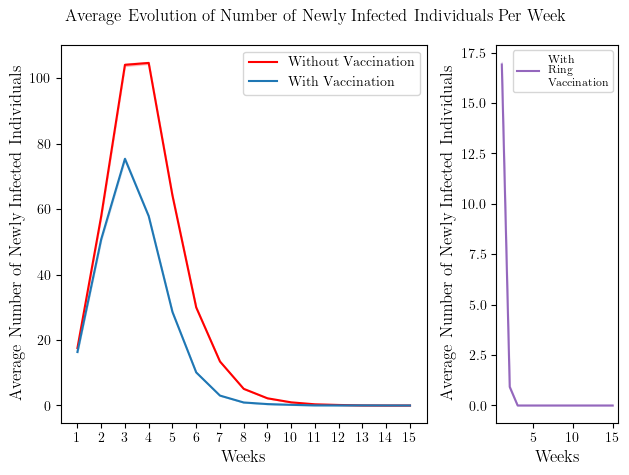

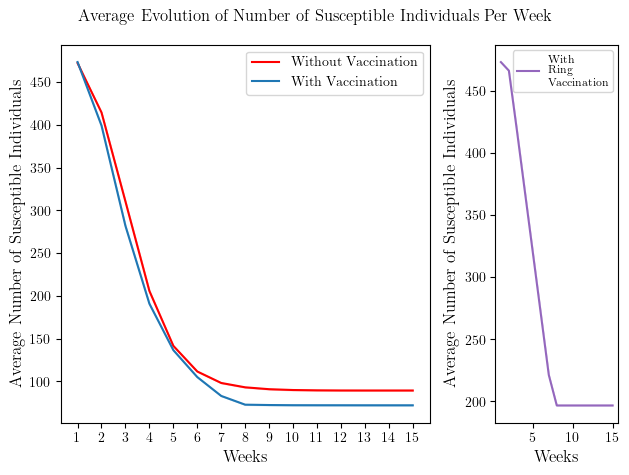

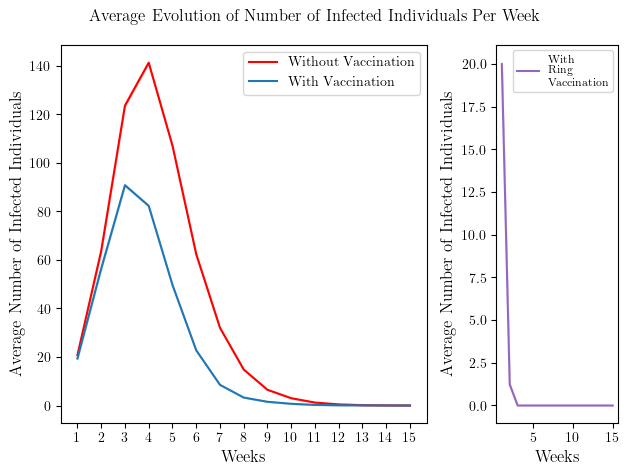

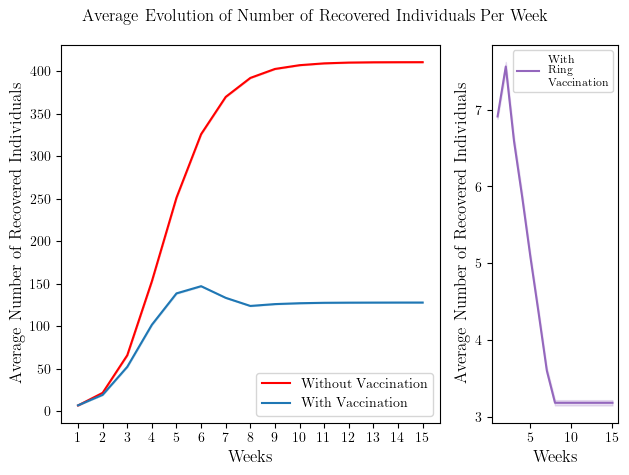

In [16]:
ni = recap_per_week["new infected"]
s = recap_per_week["s"]
i = recap_per_week["i"]
r = recap_per_week["r"]
ni_vacc = recap_per_week_vaccinated["new infected"]
s_vacc = recap_per_week_vaccinated["s"]
i_vacc = recap_per_week_vaccinated["i"]
r_vacc = recap_per_week_vaccinated["r"]
ni_vacc_ring = recap_per_week_vaccinated_ring["new infected"]
s_vacc_ring = recap_per_week_vaccinated_ring["s"]
i_vacc_ring = recap_per_week_vaccinated_ring["i"]
r_vacc_ring = recap_per_week_vaccinated_ring["r"]

for state, state_vacc, state_vacc_ring, name in zip(
    [ni,s,i,r], [ni_vacc, s_vacc, i_vacc, r_vacc], [ni_vacc_ring, s_vacc_ring, i_vacc_ring, r_vacc_ring], ["Newly Infected", "Susceptible", "Infected", "Recovered"]
):
    fig, ax = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [3, 1]})
    
    ni = state
    ni_vacc = state_vacc
    ni_vacc_ring = state_vacc_ring

    ni_mean = ni.mean(axis=0)
    ni_std = ni.std(axis=0)
    
    ni_vacc_mean = ni_vacc.mean(axis=0)
    ni_vacc_std = ni_vacc.std(axis=0)
    
    ni_vacc_ring_mean = ni_vacc_ring.mean(axis=0)
    ni_vacc_ring_std = ni_vacc_ring.std(axis=0)
    
    ci_95 = 1.96/len(ni_vacc)

    ax[0].plot(range(1,16), ni_mean, label="Without Vaccination", color="red")
    ax[0].plot(range(1,16), ni_vacc_mean, label="With Vaccination", color="tab:blue")
    
    ax[1].plot(range(1,16), ni_vacc_ring_mean, label="With \nRing \nVaccination", color="tab:purple")
    
    ax[0].fill_between(range(1,16), y1=ni_mean - ci_95 * ni_std, y2=ni_mean + ci_95 * ni_std, alpha=0.2, color="red")
    ax[0].fill_between(range(1,16), y1=ni_vacc_mean - ci_95 * ni_vacc_std, y2=ni_vacc_mean + ci_95 * ni_vacc_std, alpha=0.2, color="tab:blue")
    
    ax[1].fill_between(range(1,16), y1=ni_vacc_ring_mean - ci_95 * ni_vacc_ring_std, y2=ni_vacc_ring_mean + ci_95 * ni_vacc_ring_std, alpha=0.2, color="tab:purple")
    ax[0].set_xticks(range(1,16))
    ax[0].set_xlabel("Weeks", fontsize=12)
    ax[0].set_ylabel(f"Average Number of {name} Individuals", fontsize=12)
    ax[0].legend()
    
    ax[1].set_xlabel("Weeks", fontsize=12)
    ax[1].set_ylabel(f"Average Number of {name} Individuals", fontsize=12)
    ax[1].legend(fontsize=8)
    fig.suptitle(f"Average Evolution of Number of {name} Individuals Per Week", fontsize=12)

    fig.tight_layout()
    if save:
        fig.savefig(f"ex13_{name}.pdf")
    plt.show()

# Question (d)

For this exercise, we have decided to simulate through the last 15 weeks instead of all 16 weeks. In fact, it is reasonable to expect that the number of infected in Sweden went from 0 to 1 in week 42. To have a "fair" simulation, our system should start from 0 infected and then evolve through 16 weeks. However, starting with 0 infected is not possible - in the SIR epidemic model configurations with no infected are disconnected absorbing states. As a consequence, we decided to 'fix' to 1 the number of infected in week 1 and the nlet the system evolve through the remaining 15 weeks. 

In [17]:
def simulate_sweden(
    graph:nx.Graph, 
    vaccination_scheme:list, 
    I_0:list, 
    n_nodes:int=934, 
    N:int=10, 
    n_weeks:int=16,
    n_simulations:int=1,
    training:bool=False, 
    k:int=3, 
    beta:float=0.47719, 
    rho :float=0.065453):
    """Function to estimate k, beta, rho for the Swedish H1N1 epidemic 

    Args:
        graph (nx.Graph): initial graph. The actual Swedish network will be built upon it.
        vaccination_scheme (list): list representing Vacc(t) according to the problem specification
        I_0 (list): scaled number of newly infected individuals each week in Sweden.
        n_nodes (int, optional): number of people in the Swedish network. Defaults to 934.
        training (bool, optional): if the user wants to resimulate and find their own best tested configuration. Defaults to False.
        
        If training == True, set the parameters for the simulation:
            N (int, optional): how many times the same configuration is simulated. Defaults to 10.
            n_weeks (int, optional): number of weeks through which a given configuration is simulated. Defaults to 16.
            n_simulations (int, optional): how many different gridsearches are simulated. Each gridsearch takes ~3 min. Defaults to 1.

            So in total there are n_simulations * N * n_weeks iterations.

            The gridsearch works as follow:
                - k_0 is a random integer between 5 and 14. delta_k is set to 6.
                - beta_0 and rho_0 are random float between 0 and 1. The corresponding deltas are both set to 0.5.

                - the gridsearch is built as 
                    {
                        "K" : [k_0 - delta_k, k_0, k_0 + delta_k],
                        "Beta" : [beta_0 - delta_beta, beta_0 + delta_beta),
                        "Rho" : [rho_0 - delta_rho, rho_0 + delta_rho]
                    }
                    
                Some attention is paid to make sure the values are always valid and the same hyperparameter cannot have the same value twice.
            
        If training == False, the parameters are set as follows:
            k (int, optional): average degree k. Defaults to 13.
            beta (float, optional): probability that the infection is spread from an infected individual to a susceptible one. Defaults to 0.11.
            rho (float, optional):  probability that an infected individual will recover during one time step. Defaults to 0.437.

            These values are the results of a pre-ran tested configuration, whose yielded results can be found in the dataframe which comes with this repo.
            To work that out, we ran a simulation with N = 100 and n_simulations = 5.

    Returns:
        dict: recap per week, returning the results to answer the exercise question.
        pd.DataFrame: DataFrame containing the results of the simulations.
    """
    df_results = None
    n_infected_t0 = 1
    # "train", i.e., work out the best parameters.
    # These will be later used for simulating.
    if training:
        for i in range(n_simulations):
            # define initial parameters
            # they are all randomly chosen
            k_0 = random.randint(5, 15)
            delta_k = 6

            beta_0 = random.random()
            delta_beta = 0.5

            rho_0 = random.random()
            delta_rho = 0.5

            # keep track of the current minimum
            current_min = {"k" : None, "beta" : None, "rho" : None, "RMSE" : None}
        
            while True:
                # define parameter space
                # if the deltas are too small, break the loop
                # delta beta and delta rho are reasonably very similar (not equal for initialization)
                if delta_beta < 1e-5:
                    break

                # create a gridsearch
                parameter_space = {
                    "K" : ([max(2, k_0 - delta_k), max(3, k_0), k_0 + delta_k] if delta_k > 0 else [k_0]),
                    "Beta" : [max(0.001, beta_0 - delta_beta), min(0.999, beta_0 + delta_beta)],
                    "Rho" : [max(0.001, rho_0 - delta_rho), min(0.999, rho_0 + delta_rho)]
                }

                # store results for this configuration
                keys, values = zip(*parameter_space.items())
                df_results_this_sim = pd.DataFrame([dict(zip(keys, v)) for v in itertools.product(*values)])
                # set initial RMSE to a really big number
                df_results_this_sim["RMSE"] = int(1e8)
                
                # hide Pandas annoying warning
                pd.options.mode.chained_assignment = None 

                # iterate through the different configurations
                for k in parameter_space["K"]:
                    # cast k to an integer, to make sure it is not interpreted as a float
                    k = int(k)
                    #  generate the initial complete graph G0
                    G = nx.complete_graph(k + 1)
                    G = generate_random_graph(G, k, final_number_of_nodes)

                    # choose parameters
                    for beta in parameter_space["Beta"]:
                        for rho in parameter_space["Rho"]:
                            print(f"[{i + 1}/{n_simulations}]: ")
                            print(f"Current argmin = {current_min}")
                            print(f"k : {k_0} ± {delta_k} = {k}", end = "\t")            
                            print(f"beta : {beta_0} ± {delta_beta} = {beta}", end = "\t")            
                            print(f"rho : {rho_0} ± {delta_rho} = {rho}") 
                            # simulate contagion
                            recap_per_week = simulate_contagion(G, beta, rho, N, n_weeks, n_infected_t0=n_infected_t0, vaccination_scheme=vaccination_scheme)
                            # compute I_t
                            I_t = recap_per_week["new infected"].mean(axis=0)
                            # compute RMSE
                            RMSE = np.sqrt(np.sum((I_t - I_0)**2) / len(I_t))
                            # add RMSE to the dataframe for this configuration
                            df_results_this_sim.loc[(df_results_this_sim["K"] == k) & (df_results_this_sim["Beta"] == beta) & (df_results_this_sim["Rho"] == rho), ["RMSE"]] = RMSE

                # find the best row, i.e. the argminimiser of RMSE
                min_row = df_results_this_sim["RMSE"].argmin()
                new_min = {
                    "k" : df_results_this_sim.iloc[min_row]["K"],
                    "beta" : df_results_this_sim.iloc[min_row]["Beta"],
                    "rho" : df_results_this_sim.iloc[min_row]["Rho"],
                    "RMSE" : df_results_this_sim.iloc[min_row]["RMSE"]
                }

                # check if current_min is empty:
                if current_min["k"] is None:
                    # if empty, it means we are at the first iterations.
                    current_min = new_min.copy()
                    # update values
                    k_0 = current_min["k"]
                    beta_0 = current_min["beta"]
                    rho_0 = current_min["rho"]
                    # half all deltas            
                    delta_k = max(delta_k - 1, 0)
                    delta_beta /= 2
                    delta_rho /= 2
                # if non-empty, update.
                else:
                    # if the new minimum is smaller (with a margin) than the old minimum,
                    # update parameters and current minimum
                    if df_results_this_sim.iloc[min_row]["RMSE"] < (current_min["RMSE"] - 0.1) :
                        k_0 = new_min["k"]
                        beta_0 = new_min["beta"]
                        rho_0 = new_min["rho"]
                        current_min = new_min.copy()
                    else:
                        # the minimum has not changed. Repeat everything, halving all deltas. 
                        # k cannot become negative.            
                        delta_k = max(delta_k - 1, 0)
                        delta_beta /= 2
                        delta_rho /= 2

                # clear output
                # This make sure the user is constantly given feedback, but old information is removed
                clear_output(wait=True)

                # at the end of the simulation, store the dataframe of this simulation to the global dataframe
                if df_results is None:
                    df_results = df_results_this_sim.copy()
                else:
                    df_results = pd.concat([df_results, df_results_this_sim])
        
        # find the best amongst the best configurations
        best_configuration_idx = df_results["RMSE"].argmin()
        k, beta, rho, _ = df_results.iloc[best_configuration_idx]
        k = int(k)

    #  generate the initial complete graph G0
    G = nx.complete_graph(k + 1)
    G = generate_random_graph(G, k, n_nodes)

    N_eval = 100
    recap_per_week = simulate_contagion(G, beta, rho, N_eval, n_weeks, vaccination_scheme = vaccination_scheme, n_infected_t0=n_infected_t0)
    I_t = recap_per_week["new infected"].mean(axis=0)
    RMSE = np.sqrt(np.sum((I_t - I_0)**2) / len(I_0))

    if training:
        return I_t, df_results.sort_values(by = "RMSE", ascending = True)
    else:
        return I_t, pd.DataFrame({"k": k, "beta" : beta, "rho" : rho, "RMSE" : RMSE}, index = [0])

In [18]:
# parameters for the simulation
# how many different gridsearches are tested
n_simulations = 5
# how many times the same configuration in a gridsearch is tested
N = 10
# for how many weeks
n_weeks = 16

# parameters for the graph
final_number_of_nodes = 934

# define Vacc(t)
vacc = np.array([5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60])
vacc = vacc / 100

# set the ground truth, as per problem specifications
I_0 = [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]

I_t, df_results = simulate_sweden(G, vacc, I_0, final_number_of_nodes, N, n_weeks, n_simulations, training=False) # switch to true to perform

print(f"Tested configuration:")
display(df_results.iloc[[0]])
print(f"Predicted new number of infected per week: {I_t.mean(axis=0)}")
print(f"True new number of infected per week: {I_0}")

Simulating contagion: 100%|██████████| 100/100 [00:02<00:00, 45.99it/s]

Tested configuration:


,k,beta,rho,RMSE
0,3,0.47719,0.065453,9.05202


Predicted new number of infected per week: 12.270625
True new number of infected per week: [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]


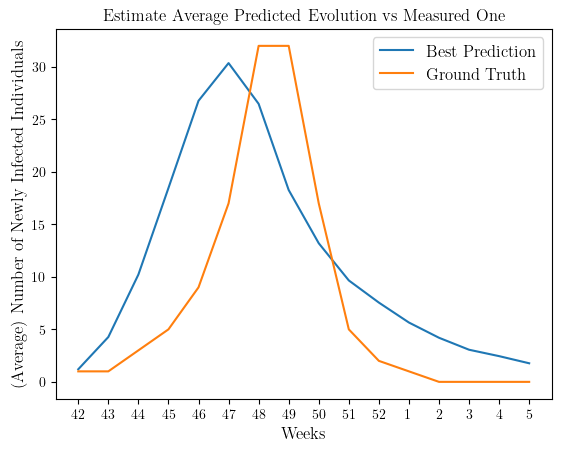

In [19]:
# fixed for reproducibility - RMSE ~5.50
best_sim = np.array([ 1.2 ,  4.27, 10.22, 18.46, 26.77, 30.36, 26.48, 18.27, 13.2 , 9.66,  7.55,  5.65,  4.2 ,  3.06,  2.45,  1.77])
I_0 = np.array([1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0])
weeks=list(range(42,53)) + list(range(1,6))

fig, ax = plt.subplots()

ax.plot(range(16), best_sim, label="Best Prediction")
ax.plot(range(16), I_0, label="Ground Truth")
ax.set_xlabel("Weeks", fontsize=12)
ax.set_ylabel("(Average) Number of Newly Infected Individuals", fontsize=12)
ax.set_title("Estimate Average Predicted Evolution vs Measured One", fontsize=12)

ax.set_xticks(range(16))
ax.set_xticklabels(weeks)

ax.legend(fontsize=12)
if save:
    fig.savefig("ex14.pdf")
plt.show()

In [20]:
# fix parameters for the loop
k = 3
final_number_of_nodes = 934

#  generate the initial complete graph G0
G = nx.complete_graph(k + 1)
G = generate_random_graph(G, k, final_number_of_nodes)

beta = 0.47719
rho = .065453

N = 10
n_weeks = 16

vacc = np.array([5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60])
vacc = vacc / 100

recap_per_week = simulate_contagion(G, beta, rho, N, n_weeks, n_infected_t0=1)
recap_per_week_vaccinated = simulate_contagion(G, beta, rho, N, n_weeks, vaccination_scheme = vacc, n_infected_t0=1)
recap_per_week_vaccinated_ring = simulate_contagion(G, beta, rho, N, n_weeks, vaccination_scheme = vacc, ring_vaccination=True, n_infected_t0=1)

Simulating contagion: 100%|██████████| 10/10 [00:00<00:00, 38.68it/s]


The following cell produces plots

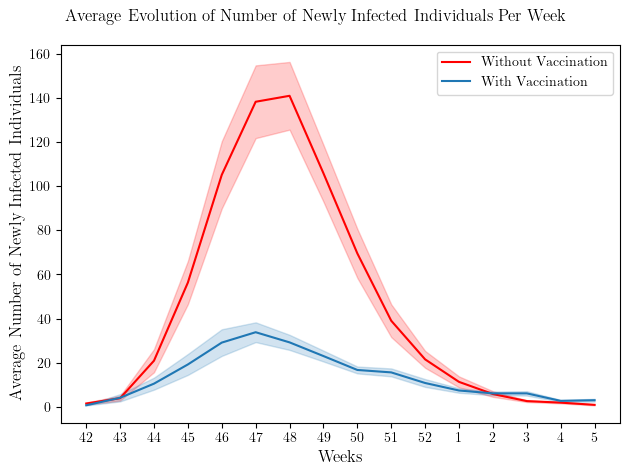

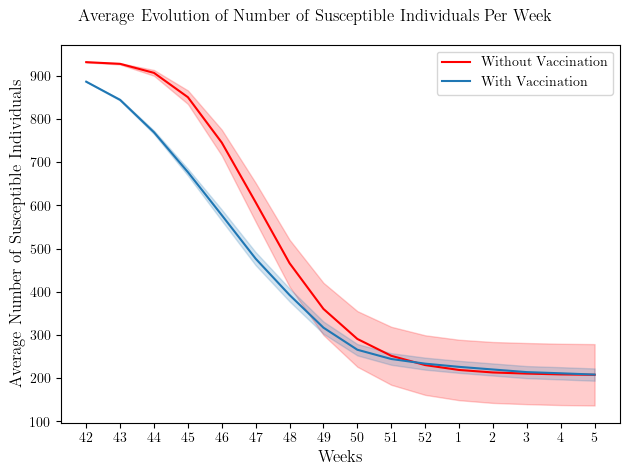

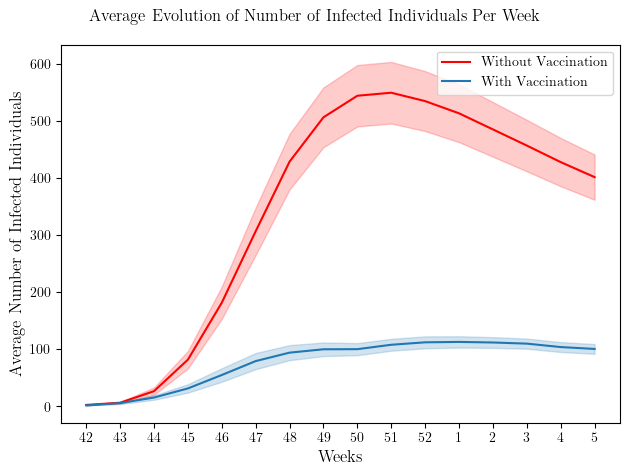

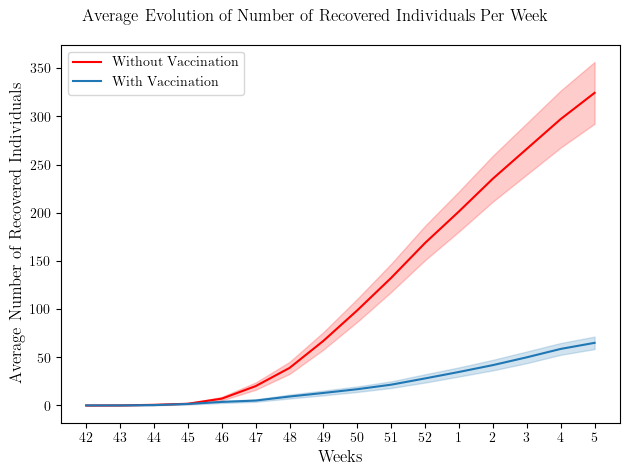

In [21]:
ni = recap_per_week["new infected"]
s = recap_per_week["s"]
i = recap_per_week["i"]
r = recap_per_week["r"]
ni_vacc = recap_per_week_vaccinated["new infected"]
s_vacc = recap_per_week_vaccinated["s"]
i_vacc = recap_per_week_vaccinated["i"]
r_vacc = recap_per_week_vaccinated["r"]
ni_vacc_ring = recap_per_week_vaccinated_ring["new infected"]
s_vacc_ring = recap_per_week_vaccinated_ring["s"]
i_vacc_ring = recap_per_week_vaccinated_ring["i"]
r_vacc_ring = recap_per_week_vaccinated_ring["r"]

weeks=list(range(42,53)) + list(range(1,6))

for state, state_vacc, state_vacc_ring, name in zip(
    [ni,s,i,r], [ni_vacc, s_vacc, i_vacc, r_vacc], [ni_vacc_ring, s_vacc_ring, i_vacc_ring, r_vacc_ring], ["Newly Infected", "Susceptible", "Infected", "Recovered"]
):
    fig, ax = plt.subplots()
    
    ni = state
    ni_vacc = state_vacc
    ni_vacc_ring = state_vacc_ring

    ni_mean = ni.mean(axis=0)
    ni_std = ni.std(axis=0)
    
    ni_vacc_mean = ni_vacc.mean(axis=0)
    ni_vacc_std = ni_vacc.std(axis=0)
    
    ni_vacc_ring_mean = ni_vacc_ring.mean(axis=0)
    ni_vacc_ring_std = ni_vacc_ring.std(axis=0)
    
    ci_95 = 1.96/len(ni_vacc)

    ax.plot(range(16), ni_mean, label="Without Vaccination", color="red")
    ax.plot(range(16), ni_vacc_mean, label="With Vaccination", color="tab:blue")

    
    ax.fill_between(range(16), y1=ni_mean - ci_95 * ni_std, y2=ni_mean + ci_95 * ni_std, alpha=0.2, color="red")
    ax.fill_between(range(16), y1=ni_vacc_mean - ci_95 * ni_vacc_std, y2=ni_vacc_mean + ci_95 * ni_vacc_std, alpha=0.2, color="tab:blue")
    
    ax.set_xticks(range(16))
    ax.set_xlabel("Weeks", fontsize=12)
    ax.set_ylabel(f"Average Number of {name} Individuals", fontsize=12)
    ax.legend()
    
    ax.set_xticklabels(weeks)
    
    fig.suptitle(f"Average Evolution of Number of {name} Individuals Per Week", fontsize=12)

    fig.tight_layout()
    if save:
        fig.savefig(f"ex14_{name}.pdf")
    plt.show()